In [4]:
import gym
import collections
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [5]:
env = gym.make('CartPole-v1')
print(env.action_space.n)
print(env.observation_space)

2
Box(4,)


# Hyperparameter

In [13]:
#Hyperparameters
learning_rate = 0.5
gamma = 0.98
buffer_limit = 50000
batch_size = 32
eps_max = 0.5
eps_min = 0.05
eps_decay_steps = 5000

# ReplayBuffer

In [14]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    # transition 집어넣어줌
    def put(self, transition):
        self.buffer.append(transition)
    
    # buffer에서 32개를 random으로 뽑아서 random batch를 만듦
    def sample(self, n):
        random_batch = random.sample(self.buffer, n)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for transition in random_batch:
            s, a, r, s_prime, done_mask = transition
            state.append(s)
            action.append([a])
            reward.append([r])
            next_state.append(s_prime)
            done.append([done_mask])

        return torch.tensor(state, dtype=torch.float), torch.tensor(action), \
               torch.tensor(reward), torch.tensor(next_state, dtype=torch.float), torch.tensor(done)
    
    def size(self):
        return len(self.buffer)

# Q Network

In [15]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        output = self.forward(obs)
        p = random.random()
        if p < epsilon:
            return random.randint(0,1)
        else : 
            return output.argmax().item()

# Train

In [16]:
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,next_state,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(next_state).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# main

In [17]:
def main():
    result = []
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 100
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    # episode = 5000
    for n_epi in range(5000):
        #epsilon decay
        epsilon = max(eps_min, eps_max - (eps_max-eps_min)* n_epi/eps_decay_steps) 
        #환경 reset
        s = env.reset()
        done = False
        while not done:   
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime
            score += r
            if done:
                break
        #샘플이 너무 작으면 안되므로 2000개가 넘으면 train을 시작한다.
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)
        #average score구함
        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, eps : {:.1f}%".format(n_epi, score/print_interval, epsilon*100))
            result.append(score)
            score = 0.0
    env.close()
    return result

# eps_max = 0.5

In [116]:
if __name__ == '__main__':
    result = main()
result

n_episode :100, score : 26.2, eps : 49.1%
n_episode :200, score : 12.6, eps : 48.2%
n_episode :300, score : 13.7, eps : 47.3%
n_episode :400, score : 15.1, eps : 46.4%
n_episode :500, score : 23.6, eps : 45.5%
n_episode :600, score : 30.2, eps : 44.6%
n_episode :700, score : 50.1, eps : 43.7%
n_episode :800, score : 77.3, eps : 42.8%
n_episode :900, score : 127.0, eps : 41.9%
n_episode :1000, score : 144.4, eps : 41.0%
n_episode :1100, score : 120.8, eps : 40.1%
n_episode :1200, score : 113.8, eps : 39.2%
n_episode :1300, score : 120.0, eps : 38.3%
n_episode :1400, score : 114.0, eps : 37.4%
n_episode :1500, score : 88.9, eps : 36.5%
n_episode :1600, score : 100.5, eps : 35.6%
n_episode :1700, score : 110.6, eps : 34.7%
n_episode :1800, score : 113.8, eps : 33.8%
n_episode :1900, score : 113.9, eps : 32.9%
n_episode :2000, score : 96.8, eps : 32.0%
n_episode :2100, score : 74.0, eps : 31.1%
n_episode :2200, score : 55.5, eps : 30.2%
n_episode :2300, score : 50.1, eps : 29.3%
n_episode 

[2624.0,
 1264.0,
 1371.0,
 1509.0,
 2356.0,
 3025.0,
 5012.0,
 7728.0,
 12702.0,
 14443.0,
 12078.0,
 11380.0,
 12002.0,
 11395.0,
 8887.0,
 10055.0,
 11059.0,
 11382.0,
 11393.0,
 9683.0,
 7399.0,
 5552.0,
 5006.0,
 6362.0,
 10403.0,
 14510.0,
 11326.0,
 14363.0,
 17514.0,
 15122.0,
 12480.0,
 9111.0,
 12440.0,
 10755.0,
 9678.0,
 7409.0,
 12132.0,
 11819.0,
 9516.0,
 11145.0,
 18206.0,
 29487.0,
 39299.0,
 33576.0,
 33338.0,
 33038.0,
 29542.0,
 30279.0,
 33256.0]

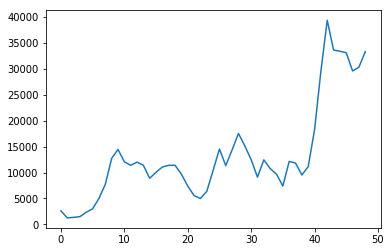

In [119]:
plt.plot(result)
plt.show()

# eps_max = 0.3

In [125]:
if __name__ == '__main__':
    result = main()
result

n_episode :100, score : 11.3, eps : 29.5%
n_episode :200, score : 15.8, eps : 29.0%
n_episode :300, score : 22.3, eps : 28.5%
n_episode :400, score : 28.9, eps : 28.0%
n_episode :500, score : 45.6, eps : 27.5%
n_episode :600, score : 38.1, eps : 27.0%
n_episode :700, score : 83.3, eps : 26.5%
n_episode :800, score : 129.7, eps : 26.0%
n_episode :900, score : 128.2, eps : 25.5%
n_episode :1000, score : 178.0, eps : 25.0%
n_episode :1100, score : 180.4, eps : 24.5%
n_episode :1200, score : 154.0, eps : 24.0%
n_episode :1300, score : 146.1, eps : 23.5%
n_episode :1400, score : 125.7, eps : 23.0%
n_episode :1500, score : 75.5, eps : 22.5%
n_episode :1600, score : 105.8, eps : 22.0%
n_episode :1700, score : 92.4, eps : 21.5%
n_episode :1800, score : 90.2, eps : 21.0%
n_episode :1900, score : 110.5, eps : 20.5%
n_episode :2000, score : 100.3, eps : 20.0%
n_episode :2100, score : 115.5, eps : 19.5%
n_episode :2200, score : 101.1, eps : 19.0%
n_episode :2300, score : 80.6, eps : 18.5%
n_episod

[1131.0,
 1580.0,
 2232.0,
 2888.0,
 4561.0,
 3814.0,
 8329.0,
 12971.0,
 12821.0,
 17803.0,
 18041.0,
 15398.0,
 14608.0,
 12565.0,
 7547.0,
 10583.0,
 9240.0,
 9018.0,
 11055.0,
 10032.0,
 11553.0,
 10108.0,
 8063.0,
 10677.0,
 14575.0,
 14786.0,
 12615.0,
 14148.0,
 13903.0,
 14026.0,
 14357.0,
 16112.0,
 25272.0,
 26531.0,
 23545.0,
 23224.0,
 28518.0,
 16363.0,
 14678.0,
 25665.0,
 21737.0,
 20509.0,
 19003.0,
 14614.0,
 12744.0,
 21231.0,
 13458.0,
 13564.0,
 26872.0]

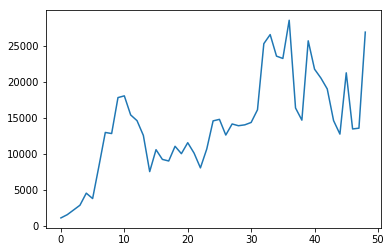

In [126]:
plt.plot(result)
plt.show()

# eps_max = 0.5 && Fully connected layer 뉴런 개수 (4,256),(256,128),(128,2) 
## 학습이 더 잘된 0.5를 선택했습니다.

In [132]:
if __name__ == '__main__':
    result = main()
result

n_episode :100, score : 13.3, eps : 49.1%
n_episode :200, score : 14.5, eps : 48.2%
n_episode :300, score : 12.6, eps : 47.3%
n_episode :400, score : 13.4, eps : 46.4%
n_episode :500, score : 15.5, eps : 45.5%
n_episode :600, score : 37.5, eps : 44.6%
n_episode :700, score : 55.9, eps : 43.7%
n_episode :800, score : 98.4, eps : 42.8%
n_episode :900, score : 152.7, eps : 41.9%
n_episode :1000, score : 155.7, eps : 41.0%
n_episode :1100, score : 156.5, eps : 40.1%
n_episode :1200, score : 113.8, eps : 39.2%
n_episode :1300, score : 104.2, eps : 38.3%
n_episode :1400, score : 95.5, eps : 37.4%
n_episode :1500, score : 85.6, eps : 36.5%
n_episode :1600, score : 80.0, eps : 35.6%
n_episode :1700, score : 83.0, eps : 34.7%
n_episode :1800, score : 74.7, eps : 33.8%
n_episode :1900, score : 65.2, eps : 32.9%
n_episode :2000, score : 59.5, eps : 32.0%
n_episode :2100, score : 60.0, eps : 31.1%
n_episode :2200, score : 78.1, eps : 30.2%
n_episode :2300, score : 84.2, eps : 29.3%
n_episode :2400

[1328.0,
 1453.0,
 1260.0,
 1342.0,
 1551.0,
 3745.0,
 5591.0,
 9838.0,
 15271.0,
 15572.0,
 15650.0,
 11383.0,
 10424.0,
 9554.0,
 8564.0,
 8002.0,
 8305.0,
 7474.0,
 6515.0,
 5952.0,
 5998.0,
 7808.0,
 8416.0,
 7783.0,
 9506.0,
 11864.0,
 13104.0,
 14784.0,
 16392.0,
 19034.0,
 17962.0,
 19035.0,
 21276.0,
 17532.0,
 26429.0,
 21153.0,
 20237.0,
 16122.0,
 20201.0,
 25201.0,
 34668.0,
 31000.0,
 27109.0,
 34090.0,
 32482.0,
 42216.0,
 32551.0,
 34599.0,
 37039.0]

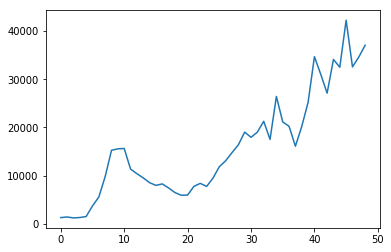

In [133]:
plt.plot(result)
plt.show()

# eps_max = 0.5 && Fully connected layer 뉴런 개수 (4,256),(256,256),(256,2) 

In [11]:
if __name__ == '__main__':
    result = main()
result

n_episode :100, score : 12.3, eps : 49.1%
n_episode :200, score : 14.3, eps : 48.2%
n_episode :300, score : 14.2, eps : 47.3%
n_episode :400, score : 21.2, eps : 46.4%
n_episode :500, score : 15.5, eps : 45.5%
n_episode :600, score : 29.0, eps : 44.6%
n_episode :700, score : 54.1, eps : 43.7%
n_episode :800, score : 69.7, eps : 42.8%
n_episode :900, score : 106.0, eps : 41.9%
n_episode :1000, score : 115.3, eps : 41.0%
n_episode :1100, score : 77.1, eps : 40.1%
n_episode :1200, score : 109.3, eps : 39.2%
n_episode :1300, score : 104.0, eps : 38.3%
n_episode :1400, score : 77.0, eps : 37.4%
n_episode :1500, score : 99.8, eps : 36.5%
n_episode :1600, score : 103.3, eps : 35.6%
n_episode :1700, score : 90.6, eps : 34.7%
n_episode :1800, score : 103.6, eps : 33.8%
n_episode :1900, score : 77.5, eps : 32.9%
n_episode :2000, score : 93.9, eps : 32.0%
n_episode :2100, score : 76.6, eps : 31.1%
n_episode :2200, score : 62.1, eps : 30.2%
n_episode :2300, score : 99.3, eps : 29.3%
n_episode :240

[1233.0,
 1434.0,
 1416.0,
 2122.0,
 1550.0,
 2898.0,
 5406.0,
 6966.0,
 10604.0,
 11528.0,
 7706.0,
 10932.0,
 10403.0,
 7704.0,
 9982.0,
 10330.0,
 9056.0,
 10364.0,
 7751.0,
 9390.0,
 7657.0,
 6212.0,
 9927.0,
 12086.0,
 21290.0,
 25006.0,
 21107.0,
 22861.0,
 36529.0,
 32673.0,
 27040.0,
 32429.0,
 21340.0,
 24761.0,
 21749.0,
 24000.0,
 28204.0,
 22774.0,
 18975.0,
 19596.0,
 18726.0,
 17428.0,
 30057.0,
 14007.0,
 13470.0,
 20247.0,
 23050.0,
 23954.0,
 24052.0]

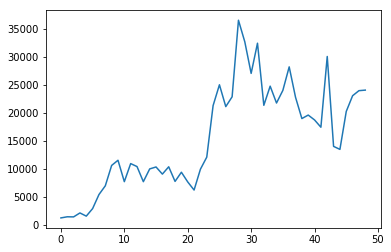

In [12]:
plt.plot(result)
plt.show()

# eps_max = 0.5 && Fully connected layer 뉴런 개수 (4,256),(256,256),(256,2) && learning rate = 0.5

In [18]:
if __name__ == '__main__':
    result = main()
result

n_episode :100, score : 17.5, eps : 49.1%
n_episode :200, score : 13.5, eps : 48.2%
n_episode :300, score : 12.6, eps : 47.3%
n_episode :400, score : 13.4, eps : 46.4%
n_episode :500, score : 13.3, eps : 45.5%
n_episode :600, score : 13.8, eps : 44.6%
n_episode :700, score : 12.8, eps : 43.7%
n_episode :800, score : 12.0, eps : 42.8%
n_episode :900, score : 12.5, eps : 41.9%
n_episode :1000, score : 12.9, eps : 41.0%
n_episode :1100, score : 12.2, eps : 40.1%
n_episode :1200, score : 13.4, eps : 39.2%
n_episode :1300, score : 12.3, eps : 38.3%
n_episode :1400, score : 12.3, eps : 37.4%
n_episode :1500, score : 12.3, eps : 36.5%
n_episode :1600, score : 11.2, eps : 35.6%
n_episode :1700, score : 11.8, eps : 34.7%
n_episode :1800, score : 11.7, eps : 33.8%
n_episode :1900, score : 11.7, eps : 32.9%
n_episode :2000, score : 11.6, eps : 32.0%
n_episode :2100, score : 11.4, eps : 31.1%
n_episode :2200, score : 11.4, eps : 30.2%
n_episode :2300, score : 11.0, eps : 29.3%
n_episode :2400, sco

[1753.0,
 1353.0,
 1264.0,
 1341.0,
 1335.0,
 1383.0,
 1282.0,
 1201.0,
 1248.0,
 1286.0,
 1225.0,
 1343.0,
 1233.0,
 1232.0,
 1235.0,
 1125.0,
 1182.0,
 1174.0,
 1173.0,
 1163.0,
 1141.0,
 1141.0,
 1099.0,
 1149.0,
 1086.0,
 1102.0,
 1084.0,
 1117.0,
 1128.0,
 1087.0,
 1082.0,
 1068.0,
 1084.0,
 1043.0,
 1057.0,
 1032.0,
 1018.0,
 1035.0,
 1030.0,
 1005.0,
 1000.0,
 1036.0,
 1022.0,
 997.0,
 990.0,
 988.0,
 988.0,
 971.0,
 954.0]

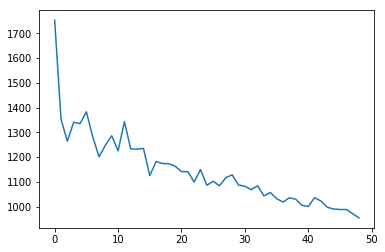

In [19]:
plt.plot(result)
plt.show()